# PARCELS Tutorial

Welcome to a quick tutorial on PARCELS. This is meant to get you started with the code, and give you a flavour of some of the key features of PARCELS.

In this tutorial, we will first cover how to run a set of particles [from a very simple idealised grid](#idealised). We will show how easy it is to run particles in [time-backward mode](#backward). Then, we will show how to [add custom behaviour](#customkernel) to the particles. Then we will show how to [run particles in a set of NetCDF files from external data](#netcdf). And finally, we will show how to [write a kernel that tracks the distance travelled by the particles](#distancekernel).

Let's start with importing the relevant modules. The key ones are all in the `parcels` directory. First load in the key functions.

In [1]:
%matplotlib inline
from parcels import *
from scripts import *
import math
from datetime import timedelta

## Running particles in an idealised grid <a name="idealised"></a>

The first step to running particles with PARCELS is to define a `grid` object. In this first case, we use a simple flow of two idealised moving eddies. That field is saved in NetCDF format in the directory `examples/MovingEddies_data`. Since we know that the files are in what's called `NEMO` format, we can call these files using the function `Grid.from_nemo()`.

In [2]:
grid = Grid.from_nemo("MovingEddies_data/moving_eddies")

The grid can then be visualised with the `show()` function. To plot an animation of the zonal velocity (`U`), give the following command

In [3]:
grid.U.show(animation=True)

The next step is to define a `ParticleSet` that lives on this grid. In this case, we start 2 particles at (3.3E, 46N) and (3.3E, 47.8N). Note that we use `JITParticle` as `pclass`, because we will be executing the advection in JIT (Just-In-Time) mode. The alternative is to run in `scipy` mode, in which case `pclass` is simply `Particle`

In [4]:
pset = grid.ParticleSet(size=2,             # the number of particles
                        pclass=JITParticle, # the type of particles (JITParticle or Particle)
                        lon=[ 3.3,  3.3],   # a vector of release longitudes 
                        lat=[46.0, 47.8])   # a vector of release latitudes

Print the `ParticleSet` to see where they start

In [5]:
print(pset)

P(3.300000, 46.000000, 0.000000)[164, 49]
P(3.300000, 47.799999, 0.000000)[164, 139]


This output shows for each particle the (longitude, latitude, depth), and then in square brackets the grid indices of the longitude and latitude.

To plot the positions of these particles on the zonal velocity, use the following command

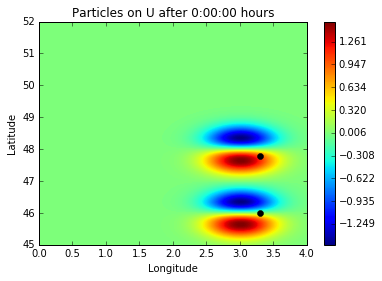

In [6]:
pset.show(field=grid.U)

The final step is to run (or 'execute') the `ParticelSet`. We run the particles using the `AdvectionRK4` kernel, which is a 4th order Runge-Kutte implementation that comes with PARCELS. We run the particles for 6 days (using the `timedelta` function from `datetime`), at an RK4 timestep of 5 minutes. We store the trajectory information at an interval of 1 hour in a file called `EddyParticles.nc`.

In [7]:
pset.execute(AdvectionRK4,                # the kernel (which defines how particles move)
             runtime=timedelta(days=6),   # the total length of the run
             dt=timedelta(minutes=5),     # the timestep of the kernel
             interval=timedelta(hours=1), # the interval at which output is stored
             output_file=pset.ParticleFile(name="EddyParticles")) # the name of the output file

Compiled JITParticleAdvectionRK4 ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/9f8658500c543573b6cb42579adb2bd9.so


The code should have run, which can be confirmed by printing and plotting the `ParticleSet` again

P(2.024544, 46.088627, 518400.000000)[100, 54]
P(2.017195, 48.305283, 518400.000000)[100, 164]


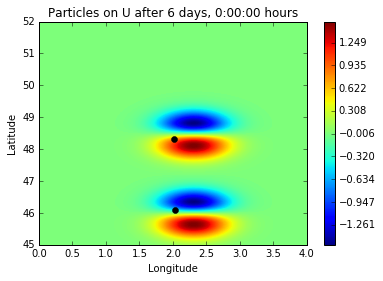

In [8]:
print(pset)
pset.show(field=grid.U)

Note that both the particles (the black dots) and the `U` field have moved in the plot above.

The trajectory information of the particles is stored in the `EddyParticles.nc` file. It can be quickly plotted using the `plotTrajectoriesFile` function.

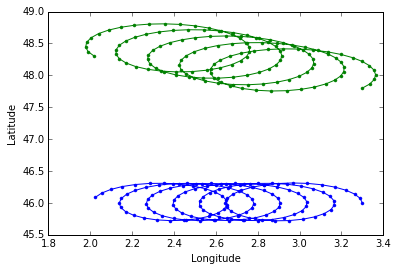

In [9]:
plotTrajectoriesFile('EddyParticles.nc')

The `plotTrajectoriesFile` function can also be used to show the trajectories as an animation, by specifying that it has to run in `movie2d_notebook` mode. If we pass this to our function above, we can watch the particles go!

In [10]:
plotTrajectoriesFile('EddyParticles.nc', mode = 'movie2d_notebook')

Now one of the neat features of PARCELS is that the particles can be plotted as a movie *during execution*, which is great for debugging. To rerun the particles while plotting them on top of the zonal velocity field (`grid.U`), first reinitialise the `ParticleSet` and then re-execute. However, now rather than saving the output to a file, display a movie using the `show_movie` keyword, in this case with the zonal velocity `grid.U` as background

In [11]:
## THIS DOES NOT WORK IN THIS IPYTHON NOTEBOOK, BECAUSE OF THE INLINE PLOTTING. 
## THE 'SHOW_MOVIE' KEYWORD WILL WORK ON MOST MACHINES, THOUGH
# pset = grid.ParticleSet(size=2, pclass=JITParticle, lon=[3.3, 3.3], lat=[46.0, 47.8])
# pset.execute(AdvectionRK4, 
#              runtime=timedelta(days=6),
#              dt=timedelta(minutes=5),
#              interval=timedelta(hours=1),
#              show_movie=grid.U)

## Running particles in backward time <a name="backward"></a>

Running particles in backward time is extremely simple: just provide a `dt` < 0. Extra keywords `startime` and `endtime` can be used to further control the length of the exection.

In [12]:
pset.execute(AdvectionRK4,
             starttime=timedelta(days=6), # the start time of the run
             dt=-timedelta(minutes=5),    # negative timestep for backward run
             endtime=timedelta(days=0),   # the end time of the run
             interval=-timedelta(hours=1),# negative interval for backward run
             output_file=pset.ParticleFile(name="EddyParticles_Bwd")) # the name of the output file

Now print the particles again, and see that they (except for some round-off errors) returned to their original position

P(3.299995, 45.999901, 0.000000)[164, 49]
P(3.299851, 47.799862, 0.000000)[164, 139]


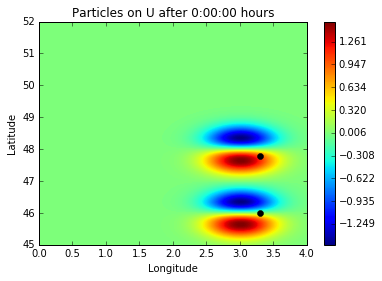

In [13]:
print(pset)
pset.show(field=grid.U)

## Adding a custom behaviour kernel <a name="customkernel"></a>

A key feature of PARCELS is the ability to quickly create very simple kernels, and add them to the execution. Kernels are little snippets of code that are run during exection of the particles.

In this example, we'll create a simple kernel where particles obtain an extra 2 m/s westward velocity after 1 day. Of course, this is not very realistic scenario, but it nicely illustrates the power of custom kernels.

In [14]:
def WestVel(particle, grid, time, dt):
    if time > 86400:
        uvel = -2.
        particle.lon += uvel * dt / 1.1e5 # 1.1e5 m in 1 degree latitude

Now reset the `ParticleSet` again, and re-execute. Note that we have now changed `kernel` to be `AdvectionRK4 + k_WestVel`, where `k_WestVel` is the `WestVel` function as defined above cast into a `Kernel` object (via the `pset.Kernel` call).

In [15]:
pset = grid.ParticleSet(size=2, pclass=JITParticle, lon=[3.3, 3.3], lat=[46.0, 47.8])

k_WestVel = pset.Kernel(WestVel)       # casting the WestVel function to a kernel object

pset.execute(AdvectionRK4 + k_WestVel, # simply add kernels using the + operator
             runtime=timedelta(days=3), 
             dt=timedelta(minutes=5), 
             interval=timedelta(hours=1),
             output_file=pset.ParticleFile(name="EddyParticles_WestVel"))

Compiled JITParticleAdvectionRK4WestVel ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/42db79cc91d56809425b7fa912780235.so


And now plot this new trajectory file

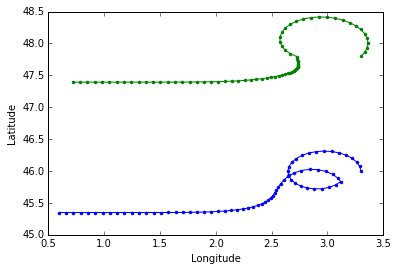

In [16]:
plotTrajectoriesFile('EddyParticles_WestVel.nc')

## Reading in data from arbritrary NetCDF files <a name="netcdf"></a>

In most cases, you will want to advect particles within pre-computed velocity fields. If these velocity fields are stored in NetCDF format, it is fairly easy to load them into the `Grid.from_netcdf()` function.

The `examples` directory contains a set of [GlobCurrent](http://globcurrent.ifremer.fr/products-data/products-overview) files of the region around South Africa. 

First, define the names of the files containing the zonal (U) and meridional (V) velocities. You can use wildcards (`*`) and the filenames for U and V can be the same (as in this case)

In [17]:
filenames = {'U': "GlobCurrent_example_data/20*.nc",
             'V': "GlobCurrent_example_data/20*.nc"}

Then, define a dictionary of the variables (`U` and `V`) and dimensions (`lon`, `lat` and `time`; note that in this case there is no `depth` because the GlobCurrent data is only for the surface of the ocean)

In [18]:
variables = {'U': 'eastward_eulerian_current_velocity', 
             'V': 'northward_eulerian_current_velocity'}
dimensions = {'lat': 'lat', 
              'lon': 'lon', 
              'time': 'time'}

Finally, read in the grid using the `Grid.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`

In [19]:
grid = Grid.from_netcdf(filenames, variables, dimensions)

Now define a `ParticleSet`, in this case with 10 particle starting on a line between (28E, 33S) and (30E, 33S)

In [20]:
pset = grid.ParticleSet(size=5,           # releasing 5 particles
                        pclass=JITParticle,
                        start=(28, -33),  # releasing on a line: the start longitude and latitude
                        finish=(30, -33)) # releasing on a line: the end longitude and latitude

And finally execute the `ParticleSet` for 1 week using 4th order Runge-Kutta

In [21]:
pset.execute(AdvectionRK4, 
             runtime=timedelta(days=10),
             dt=timedelta(minutes=5),
             interval=timedelta(hours=6),
             output_file=pset.ParticleFile(name="GlobCurrentParticles"))

Now visualise this simulation using the `plotParticles` script again. Note you can plot the particles on top of one of the velocity fields using the `tracerfile`, `tracerfield`, etc keywords.

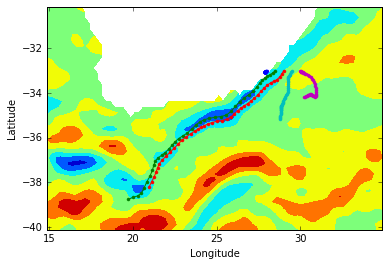

In [22]:
plotTrajectoriesFile('GlobCurrentParticles.nc', 
                     tracerfile='GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc', 
                     tracerlon='lon', 
                     tracerlat='lat', 
                     tracerfield='eastward_eulerian_current_velocity')

## A second example kernel: calculating distance travelled <a name ="distancekernel"></a>

As a second example of what custom kernels can do, we will now show how to create a kernel that logs the total distance that particles have travelled.

First, we need to create a new `ParticleSet` class that includes a few extra variables (called `user_vars` in PARCELS)

In [23]:
class DistParticle(JITParticle):          # Define a new particle class that contains
    user_vars = {'distance': np.float32,  # three new variables: the distance as well as 
                 'prev_lon': np.float32,  # the previous longitude and
                 'prev_lat': np.float32}  # the previous latitude.
    
    def __init__(self, *args, **kwargs):
        # Inheritance of other fields for new particles
        super(DistParticle, self).__init__(*args, **kwargs)
        # Set default values for the three new variables
        self.distance = 0.
        self.prev_lon = self.lon
        self.prev_lat = self.lat

Now define a new function `totaldistance` that calculates the sum of Euclidean distances between the old and new locations in each RK4 step

In [24]:
def totaldistance(particle, grid, time, dt):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi /180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon        # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

We will run this on a `ParticleSet` containing the two particles within the idealised moving eddies grid from above. Note that `pclass=DistParticle` in this case

In [25]:
grid = Grid.from_nemo("MovingEddies_data/moving_eddies")
pset = grid.ParticleSet(size=2, pclass=DistParticle, lon=[3.3, 3.3], lat=[46.0, 47.8])

Again define a new kernel to include the function written above and execute the `ParticleSet`.

In [26]:
k_dist = pset.Kernel(totaldistance)    # Casting the totaldistance function to a kernel.

pset.execute(AdvectionRK4 + k_dist,    # Add kernels using the + operator.
             runtime=timedelta(days=6),
             dt=timedelta(minutes=5),
             interval=timedelta(hours=1),
             output_file=pset.ParticleFile(name="EddyParticles_Dist"))

Compiled DistParticleAdvectionRK4totaldistance ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/d9cdd7b2953b59014df59895ec4f3b21.so


And finally print the distance that each particle has travelled (note that this is also stored in the `EddyParticles_Dist.nc` file)

In [27]:
for particle in pset:           # Print the distance (in km) travelled by the particles.
    print(particle.distance)

952.563
990.173
